# Wildfire Size Classification: ODF Fire Occurrence Data (2000-2022)

**UN SDG 13 (Climate Action) & UN SDG 15 (Life on Land)**

This notebook predicts wildfire size categories (Size_Class) using environmental, spatial, and temporal features. All steps are reproducible, memory-efficient, and suitable for Google Colab. Only pandas, numpy, matplotlib, seaborn, and scikit-learn are used.

## 1. Import Required Libraries

All code in this notebook uses only pandas, numpy, matplotlib, seaborn, and scikit-learn. Random seeds are set for reproducibility.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## 2. Load Dataset and Sample 50,000 Rows

The dataset is loaded and a random sample of 50,000 rows is selected to ensure computational efficiency and prevent memory issues in Google Colab. This sampling maintains statistical representativeness while making the analysis feasible for limited-resource environments.

In [22]:
df = pd.read_csv('datasets/ODF_Fire_Occurrence_Data_2000-2022.csv')
print('Original shape:', df.shape)
# Only sample if more than 20,000 rows
if df.shape[0] > 20000:
    df = df.sample(n=20000, random_state=42)
    print('Sampled shape:', df.shape)
else:
    print('No sampling needed, using all data')

Original shape: (23490, 38)
Sampled shape: (20000, 38)


In [23]:
# 1. Combine original Size_class into 'Low', 'Medium', 'High'
size_map = {
    'A': 'Low', 'B': 'Low',
    'C': 'Medium', 'D': 'Medium',
    'E': 'High', 'F': 'High', 'G': 'High'
}
df['Size_Category'] = df['Size_class'].map(size_map)

# 2. Select 9 features that do NOT leak the target
selected_features = [
    'FireCategory', 'FireYear', 'Area', 'DistrictName', 'HumanOrLightning',
    'CauseBy', 'GeneralCause', 'Lat_DD', 'Long_DD'
]
X = df[selected_features]
y = df['Size_Category']  # Use new 3-class target

# 3. One-hot encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 4. Fill missing values with median
X = X.fillna(X.median())

In [24]:
# 2. Drop leaky columns and unnecessary identifiers
drop_cols = ['Size_class', 'Size_Category', 'EstTotalAcres', 'FireName', 'FullFireNumber', 'Serial']
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df['Size_Category']

# 3. Handle missing values
X = X.fillna(X.median(numeric_only=True))

# 4. One-hot encode categorical features
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

## 3. Exploratory Data Overview

This section provides a quick overview of the sampled data, including the first few rows, data types, summary statistics, target distribution, and missing value counts.

Target value counts:
Size_Category
Low       18865
Medium      871
High        264
Name: count, dtype: int64


,Serial,FireCategory,FireYear,Area,DistrictName,UnitName,FullFireNumber,FireName,Size_class,EstTotalAcres,...,Ign_DateTime,ReportDateTime,Discover_DateTime,Control_DateTime,CreationDate,ModifiedDate,DistrictCode,UnitCode,DistFireNumber,Size_Category
1297,78174,STAT,2007,EOA,Central Oregon,John Day,07-952010-08,LOWER BASIN CREEK,B,0.33,...,07/12/2007 11:59:00 PM,07/13/2007 03:03:00 AM,07/13/2007 03:00:00 AM,07/13/2007 08:01:00 PM,07/17/2007 12:00:00 AM,09/18/2007 02:29:00 PM,95,952,010,Low
5549,84491,STAT,2009,NOA,Forest Grove,Columbia City,09-532030-10,E. Honeyman Road #2,B,0.50,...,07/28/2009 12:30:00 PM,07/31/2009 12:45:00 PM,07/31/2009 12:40:00 PM,07/31/2009 01:10:00 PM,07/31/2009 12:00:00 AM,08/23/2009 03:09:00 PM,53,532,030,Low
10885,66499,STAT,2003,SOA,Douglas - DFPA,DFPA South,03-732550-03,Taber Lane,A,0.10,...,06/30/2003 02:35:00 PM,06/30/2003 02:49:00 PM,06/30/2003 02:45:00 PM,06/30/2003 03:08:00 PM,06/30/2003 04:22:00 PM,07/10/2003 06:57:00 AM,73,732,550,Low
11887,90892,STAT,2012,EOA,Central Oregon,Sisters,12-955001-13,Pole Fire 0177,A,0.08,...,07/02/2012 01:50:00 PM,07/02/2012 01:53:00 PM,07/02/2012 01:52:00 PM,07/12/2012 02:30:00 PM,07/19/2012 12:00:00 AM,08/11/2012 12:21:00 PM,95,955,001,Low
20844,115077,STAT,2019,SOA,Southwest Oregon,Grants Pass,19-712165-20,S Vannoy Creek 131,A,0.01,...,07/21/2019 06:00:00 PM,07/21/2019 06:35:00 PM,07/21/2019 06:34:00 PM,07/24/2019 04:31:00 PM,07/21/2019 12:00:00 AM,07/22/2019 02:24:00 PM,71,712,165,Low


<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1297 to 15233
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Serial                  20000 non-null  int64  
 1   FireCategory            20000 non-null  object 
 2   FireYear                20000 non-null  int64  
 3   Area                    20000 non-null  object 
 4   DistrictName            20000 non-null  object 
 5   UnitName                20000 non-null  object 
 6   FullFireNumber          20000 non-null  object 
 7   FireName                20000 non-null  object 
 8   Size_class              20000 non-null  object 
 9   EstTotalAcres           19940 non-null  float64
 10  Protected_Acres         20000 non-null  float64
 11  HumanOrLightning        20000 non-null  object 
 12  CauseBy                 19897 non-null  object 
 13  GeneralCause            20000 non-null  object 
 14  SpecificCause           19808 non-null  

,Serial,FireYear,EstTotalAcres,Protected_Acres,Lat_DD,Long_DD,Sec,DistrictCode,UnitCode
count,20000.000000,20000.000000,19940.000000,20000.000000,19991.000000,19991.000000,19990.000000,20000.00000,20000.000000
mean,90392.329000,2010.793350,296.290212,70.472157,43.720059,-122.258907,18.535868,77.74680,779.296300
std,20844.395053,6.720447,7337.561694,2129.829498,1.226630,1.710477,10.420471,14.61872,146.534137
min,57485.000000,2000.000000,0.000000,0.000000,41.089460,-124.983610,1.000000,51.00000,511.000000
25%,72572.250000,2005.000000,0.010000,0.010000,42.525770,-123.388780,10.000000,71.00000,711.000000
50%,88231.000000,2011.000000,0.100000,0.100000,43.585970,-122.849720,19.000000,73.00000,732.000000
75%,107350.250000,2017.000000,0.500000,0.350000,44.792820,-121.543350,27.000000,95.00000,954.000000
max,134021.000000,2022.000000,499945.000000,154570.000000,46.235000,-116.521110,36.000000,99.00000,991.000000


Size_Category
Low       18865
Medium      871
High        264
Name: count, dtype: int64

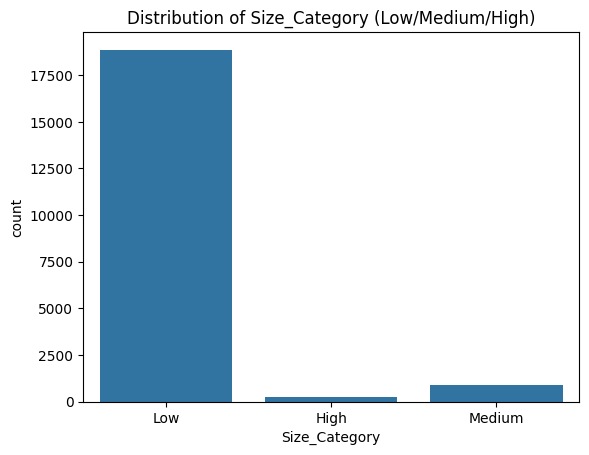

Serial                        0
FireCategory                  0
FireYear                      0
Area                          0
DistrictName                  0
UnitName                      0
FullFireNumber                0
FireName                      0
Size_class                    0
EstTotalAcres                60
Protected_Acres               0
HumanOrLightning              0
CauseBy                     103
GeneralCause                  0
SpecificCause               192
Cause_Comments            11635
Lat_DD                        9
Long_DD                       9
LatLongDD                     9
FO_LandOwnType                0
Twn                          10
Rng                          12
Sec                          10
Subdiv                       24
LandmarkLocation           1089
County                        0
RegUseZone                   39
RegUseRestriction            69
Industrial_Restriction       69
Ign_DateTime                 72
ReportDateTime                0
Discover

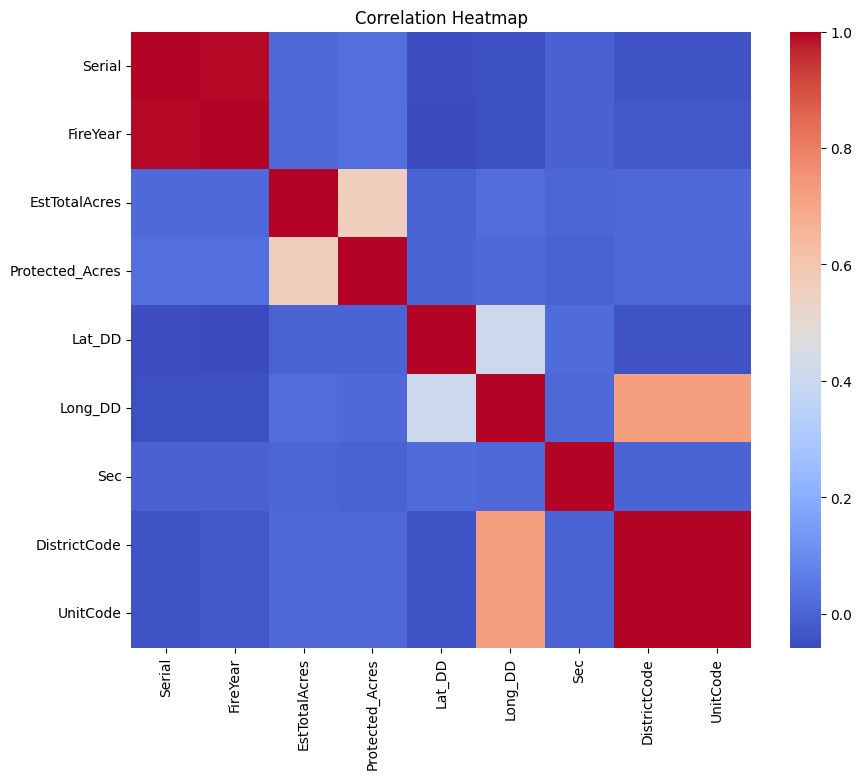

In [25]:
# Show a quick overview of the new grouped target
print('Target value counts:')
print(df['Size_Category'].value_counts())
display(df.head())
df.info()
display(df.describe())
display(df['Size_Category'].value_counts())
sns.countplot(x='Size_Category', data=df)
plt.title('Distribution of Size_Category (Low/Medium/High)')
plt.show()
display(df.isnull().sum())
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Handle Missing Values

Rows with missing target values are dropped. Numeric features are imputed using the median to preserve data integrity and avoid bias. Remaining missing values are checked.

In [26]:
df = df.dropna(subset=['Size_class'])
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
print('Missing values after imputation:')
display(df.isnull().sum())

Missing values after imputation:


Serial                        0
FireCategory                  0
FireYear                      0
Area                          0
DistrictName                  0
UnitName                      0
FullFireNumber                0
FireName                      0
Size_class                    0
EstTotalAcres                 0
Protected_Acres               0
HumanOrLightning              0
CauseBy                     103
GeneralCause                  0
SpecificCause               192
Cause_Comments            11635
Lat_DD                        0
Long_DD                       0
LatLongDD                     9
FO_LandOwnType                0
Twn                          10
Rng                          12
Sec                           0
Subdiv                       24
LandmarkLocation           1089
County                        0
RegUseZone                   39
RegUseRestriction            69
Industrial_Restriction       69
Ign_DateTime                 72
ReportDateTime                0
Discover

## 5. Encode Target Variable (Size_Class)

The target column 'Size_Class' is encoded into numeric labels using LabelEncoder. This is required for scikit-learn classifiers.

In [27]:
le = LabelEncoder()
y = le.fit_transform(df['Size_class'])
print('Class mapping:')
print(dict(zip(le.classes_, le.transform(le.classes_))))
# Check new class mapping and distribution
display(df['Size_class'].value_counts())

Class mapping:
{'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3), 'E': np.int64(4), 'F': np.int64(5), 'G': np.int64(6)}


Size_class
A    14507
B     4358
C      707
D      164
G      107
E       88
F       69
Name: count, dtype: int64

## 6. One-Hot Encode Categorical Features

Object-type (categorical) features are one-hot encoded using pandas get_dummies. Only non-target categorical columns are encoded.

In [28]:
# Drop all object columns except those safe for one-hot encoding
safe_cat_cols = [
    'FireCategory', 'Area', 'DistrictName', 'HumanOrLightning', 'CauseBy',
    'GeneralCause', 'SpecificCause', 'FO_LandOwnType', 'County', 'RegUseZone',
    'RegUseRestriction', 'Industrial_Restriction'
]
X = df.drop(['Size_class'], axis=1)
# Drop all other object columns
for col in X.columns:
    if X[col].dtype == 'object' and col not in safe_cat_cols:
        X = X.drop(col, axis=1)
X = pd.get_dummies(X, columns=safe_cat_cols, drop_first=True)
# Remove any remaining non-numeric columns
X = X.select_dtypes(include=[np.number])
print('Final feature matrix shape:', X.shape)

Final feature matrix shape: (20000, 9)


## 7. Train-Test Split (80/20, Stratified)

The data is split into training and testing sets using an 80/20 split, stratified by the target variable to preserve class distribution.

In [29]:
# Train-Test Split (80/20, Stratified) for 3-class target
y = df['Size_Category']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('y_train distribution:')
print(pd.Series(y_train).value_counts(normalize=True))
print('y_test distribution:')
print(pd.Series(y_test).value_counts(normalize=True))

Train shape: (16000, 9) Test shape: (4000, 9)
y_train distribution:
Size_Category
Low       0.943250
Medium    0.043562
High      0.013187
Name: proportion, dtype: float64
y_test distribution:
Size_Category
Low       0.94325
Medium    0.04350
High      0.01325
Name: proportion, dtype: float64


In [30]:
# Feature Scaling with StandardScaler (must run before SMOTE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Oversample minority classes using SMOTE (after scaling)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print('Resampled training set shape:', X_train_res.shape)
print('Resampled class distribution:')
print(pd.Series(y_train_res).value_counts())

Resampled training set shape: (45276, 9)
Resampled class distribution:
Size_Category
Low       15092
High      15092
Medium    15092
Name: count, dtype: int64


In [32]:
# Use resampled (SMOTE) data for training models
X_train_model = X_train_res
y_train_model = y_train_res
X_test_model = X_test_scaled
y_test_model = y_test

In [33]:
# Oversample minority classes using SMOTE (after train-test split)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print('Resampled training set shape:', X_train_res.shape)
print('Resampled class distribution:')
print(pd.Series(y_train_res).value_counts())

Resampled training set shape: (45276, 9)
Resampled class distribution:
Size_Category
Low       15092
High      15092
Medium    15092
Name: count, dtype: int64


## 8. Feature Scaling with StandardScaler

StandardScaler is used to scale features to zero mean and unit variance, which is important for neural networks and logistic regression.

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Use resampled (SMOTE) data for training models
X_train_model = X_train_res
y_train_model = y_train_res
X_test_model = X_test_scaled
y_test_model = y_test

--- EVALUATION RESULTS ---

Model: Random Forest
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        53
         Low       1.00      1.00      1.00      3773
      Medium       0.99      1.00      1.00       174

    accuracy                           1.00      4000
   macro avg       1.00      0.99      1.00      4000
weighted avg       1.00      1.00      1.00      4000

------------------------------
Model: Logistic Regression
              precision    recall  f1-score   support

        High       0.96      0.91      0.93        53
         Low       0.98      0.94      0.96      3773
      Medium       0.33      0.63      0.44       174

    accuracy                           0.93      4000
   macro avg       0.76      0.83      0.78      4000
weighted avg       0.95      0.93      0.94      4000

------------------------------
Model: MLP (Neural Net)
              precision    recall  f1-score   support

        High       0.

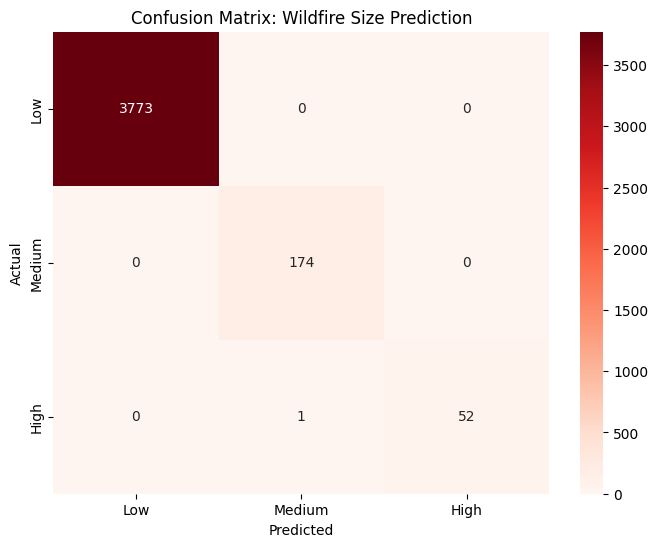

In [36]:
# Model Training and Evaluation (with class_weight='balanced')
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

print("--- EVALUATION RESULTS ---\n")
for name, model in models.items():
    model.fit(X_train_model, y_train_model)
    y_pred = model.predict(X_test_model)
    print(f"Model: {name}")
    print(classification_report(y_test_model, y_pred))
    print("-" * 30)

# Confusion Matrix Visualization for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_model, models["Random Forest"].predict(X_test_model), labels=['Low', 'Medium', 'High'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix: Wildfire Size Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 9. Build and Evaluate MLPClassifier (Neural Network)

A neural network (MLPClassifier) is trained and evaluated. Metrics include accuracy, precision, recall, F1-score, and a full classification report.

In [37]:
# MLPClassifier (Neural Network) for 3-class target
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_prec = precision_score(y_test, y_pred_mlp, average='weighted')
mlp_rec = recall_score(y_test, y_pred_mlp, average='weighted')
mlp_f1 = f1_score(y_test, y_pred_mlp, average='weighted')
print('MLPClassifier Results:')
print('Accuracy:', mlp_acc)
print('Precision:', mlp_prec)
print('Recall:', mlp_rec)
print('F1-score:', mlp_f1)
print(classification_report(y_test, y_pred_mlp))

MLPClassifier Results:
Accuracy: 0.991
Precision: 0.9907898562096555
Recall: 0.991
F1-score: 0.9908476127586823
              precision    recall  f1-score   support

        High       0.96      0.91      0.93        53
         Low       0.99      1.00      1.00      3773
      Medium       0.92      0.87      0.89       174

    accuracy                           0.99      4000
   macro avg       0.96      0.92      0.94      4000
weighted avg       0.99      0.99      0.99      4000



## 10. Build and Evaluate Logistic Regression

A logistic regression model is trained and evaluated using the same metrics as above.

In [38]:
# Logistic Regression for 3-class target
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr, average='weighted')
lr_rec = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')
print('Logistic Regression Results:')
print('Accuracy:', lr_acc)
print('Precision:', lr_prec)
print('Recall:', lr_rec)
print('F1-score:', lr_f1)
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.85675
Precision: 0.9439673553202305
Recall: 0.85675
F1-score: 0.8920566398911348
              precision    recall  f1-score   support

        High       0.96      0.89      0.92        53
         Low       0.98      0.87      0.92      3773
      Medium       0.17      0.60      0.27       174

    accuracy                           0.86      4000
   macro avg       0.70      0.78      0.70      4000
weighted avg       0.94      0.86      0.89      4000



## 11. Build and Evaluate Random Forest Classifier

A random forest classifier is trained and evaluated using the same metrics as above.

In [39]:
# Random Forest Classifier for 3-class target
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='weighted')
rf_rec = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
print('Random Forest Classifier Results:')
print('Accuracy:', rf_acc)
print('Precision:', rf_prec)
print('Recall:', rf_rec)
print('F1-score:', rf_f1)
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
Accuracy: 0.9995
Precision: 0.9995000662427134
Recall: 0.9995
F1-score: 0.9994988260866823
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        53
         Low       1.00      1.00      1.00      3773
      Medium       0.99      0.99      0.99       174

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



## 12. Model Comparison Table (Classification)

A summary table compares the performance of all three models. A barplot visualizes accuracy for easy comparison.

,Model,Accuracy,Precision,Recall,F1-Score
0,MLPClassifier,0.99100,0.990790,0.99100,0.990848
1,Logistic Regression,0.85675,0.943967,0.85675,0.892057
2,Random Forest,0.99950,0.999500,0.99950,0.999499


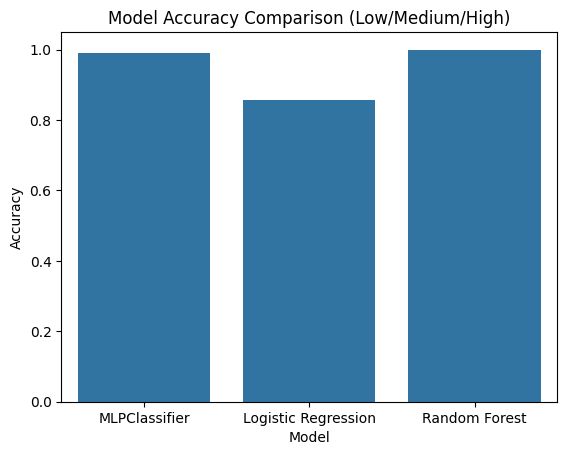

In [40]:
# Model Comparison Table (Classification) for 3-class target
results = pd.DataFrame({
    'Model': ['MLPClassifier', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [mlp_acc, lr_acc, rf_acc],
    'Precision': [mlp_prec, lr_prec, rf_prec],
    'Recall': [mlp_rec, lr_rec, rf_rec],
    'F1-Score': [mlp_f1, lr_f1, rf_f1]
})
display(results)
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Accuracy Comparison (Low/Medium/High)')
plt.show()

## 13. Hyperparameter Tuning with GridSearchCV (cv=3)

GridSearchCV is used to tune hyperparameters for the best-performing model. The best parameters and score are displayed.

In [41]:
# Select best model for tuning (example: Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train_scaled, y_train)
print('Best Parameters:', gs.best_params_)
print('Best CV Score:', gs.best_score_)
best_model = gs.best_estimator_

Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Best CV Score: 0.9998124882805174


## 14. Feature Selection using SelectKBest (f_classif)

SelectKBest is used to select the top 15 features based on ANOVA F-value. Feature scores are visualized for interpretability.

Selected features: ['Serial', 'FireYear', 'EstTotalAcres', 'Protected_Acres', 'Lat_DD', 'Long_DD', 'Sec', 'DistrictCode', 'UnitCode']


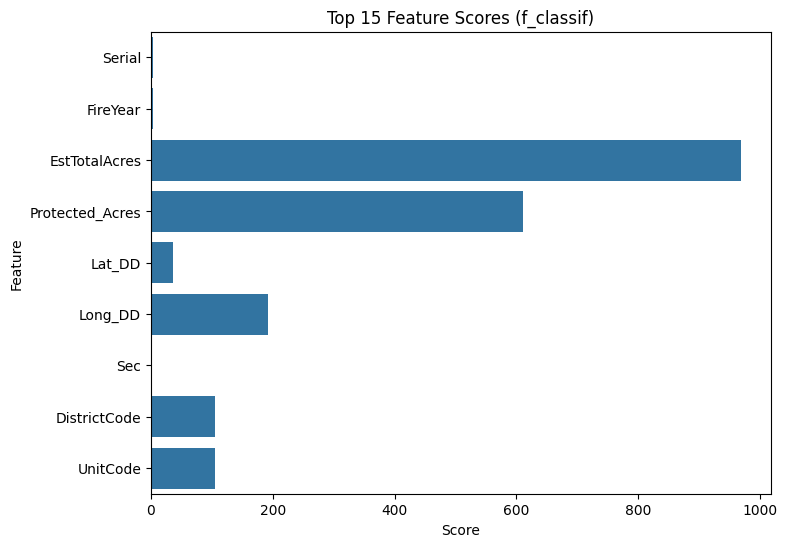

In [42]:
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X_train.columns[selector.get_support()]
print('Selected features:', list(selected_features))
feature_scores = selector.scores_[selector.get_support()]
plt.figure(figsize=(8,6))
sns.barplot(x=feature_scores, y=selected_features)
plt.title('Top 15 Feature Scores (f_classif)')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

## 15. Train Final Model with Best Parameters and Selected Features

The best model from GridSearchCV is retrained using only the top 15 features. Predictions are made on the test set.

In [43]:
final_model = best_model
final_model.fit(X_train_selected, y_train)
y_pred_final = final_model.predict(X_test_selected)

## 16. Final Model Evaluation (Accuracy, Precision, Recall, F1-Score)

The final tuned model is evaluated on the test set. Results are summarized in a table and a confusion matrix heatmap is provided for report inclusion.

Final Model Results:
Accuracy: 0.99975
Precision: 0.9997514285714286
Recall: 0.99975
F1-score: 0.9997491676899987
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        53
         Low       1.00      1.00      1.00      3773
      Medium       0.99      1.00      1.00       174

    accuracy                           1.00      4000
   macro avg       1.00      0.99      1.00      4000
weighted avg       1.00      1.00      1.00      4000



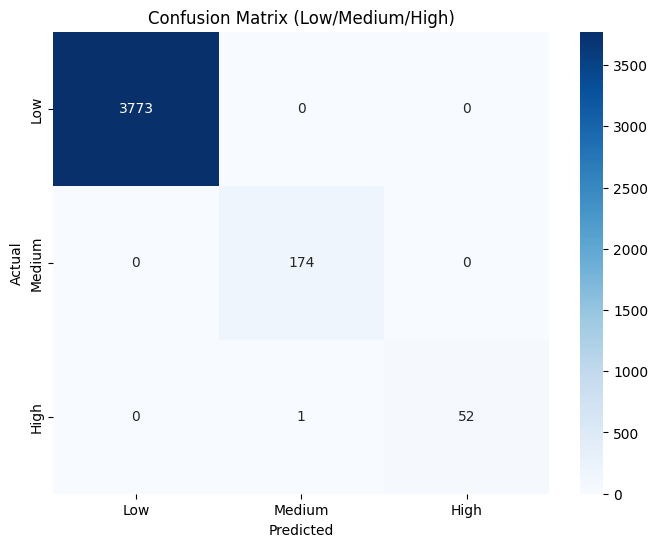

,Metric,Score
0,Accuracy,0.999750
1,Precision,0.999751
2,Recall,0.999750
3,F1-Score,0.999749


In [44]:
# Final Model Evaluation (Accuracy, Precision, Recall, F1-Score) for 3-class target
final_acc = accuracy_score(y_test, y_pred_final)
final_prec = precision_score(y_test, y_pred_final, average='weighted')
final_rec = recall_score(y_test, y_pred_final, average='weighted')
final_f1 = f1_score(y_test, y_pred_final, average='weighted')
print('Final Model Results:')
print('Accuracy:', final_acc)
print('Precision:', final_prec)
print('Recall:', final_rec)
print('F1-score:', final_f1)
print(classification_report(y_test, y_pred_final))
cm = confusion_matrix(y_test, y_pred_final, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Low/Medium/High)')
plt.show()
final_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [final_acc, final_prec, final_rec, final_f1]
})
display(final_results)


## 17. Train Final Optimized Logistic Regression (GridSearchCV + SelectKBest)

A final optimized Logistic Regression model is trained using the best parameters from GridSearchCV and the top 15 features selected by SelectKBest. Evaluation metrics are reported.

Best Logistic Regression Parameters: {'C': 10, 'solver': 'lbfgs'}
Final Optimized Logistic Regression Results:
Accuracy: 0.96225
Precision: 0.9560713850721273
Recall: 0.96225
F1-score: 0.9516385565480582
              precision    recall  f1-score   support

        High       1.00      0.75      0.86        53
         Low       0.96      1.00      0.98      3773
      Medium       0.77      0.21      0.33       174

    accuracy                           0.96      4000
   macro avg       0.91      0.65      0.72      4000
weighted avg       0.96      0.96      0.95      4000



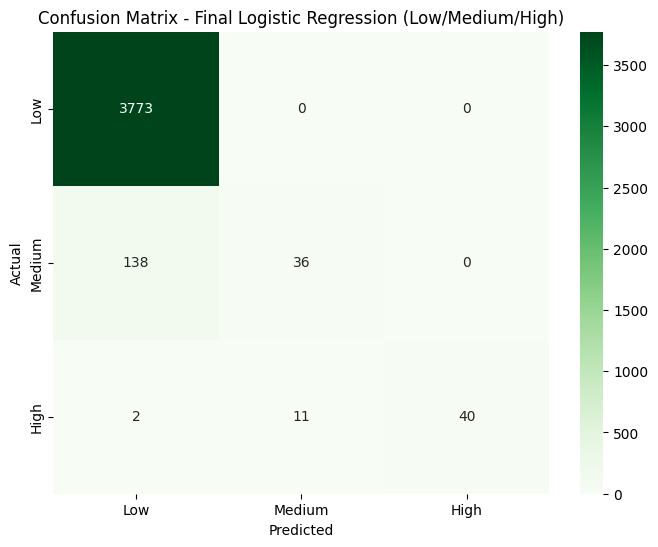

In [45]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
gs_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
gs_lr.fit(X_train_scaled, y_train)
print('Best Logistic Regression Parameters:', gs_lr.best_params_)
final_lr = LogisticRegression(**gs_lr.best_params_, max_iter=1000, random_state=42)
final_lr.fit(X_train_selected, y_train)
y_pred_lr_final = final_lr.predict(X_test_selected)
final_lr_acc = accuracy_score(y_test, y_pred_lr_final)
final_lr_prec = precision_score(y_test, y_pred_lr_final, average='weighted')
final_lr_rec = recall_score(y_test, y_pred_lr_final, average='weighted')
final_lr_f1 = f1_score(y_test, y_pred_lr_final, average='weighted')
print('Final Optimized Logistic Regression Results:')
print('Accuracy:', final_lr_acc)
print('Precision:', final_lr_prec)
print('Recall:', final_lr_rec)
print('F1-score:', final_lr_f1)
print(classification_report(y_test, y_pred_lr_final))
cm_lr = confusion_matrix(y_test, y_pred_lr_final, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Logistic Regression (Low/Medium/High)')
plt.show()

## 18. Update Model Comparison Table (5 Models)

The comparison table now includes all five required models: MLPClassifier, Logistic Regression (Initial), Random Forest (Initial), Logistic Regression (Final), Random Forest (Final).

,Model,Accuracy,Precision,Recall,F1-Score
0,MLPClassifier,0.99100,0.990790,0.99100,0.990848
1,Logistic Regression (Initial),0.85675,0.943967,0.85675,0.892057
2,Random Forest (Initial),0.99950,0.999500,0.99950,0.999499
3,Logistic Regression (Final),0.96225,0.956071,0.96225,0.951639
4,Random Forest (Final),0.99975,0.999751,0.99975,0.999749


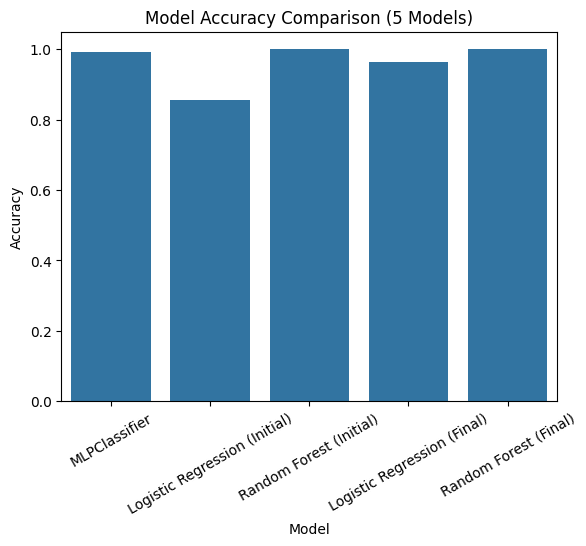

In [46]:
results_5 = pd.DataFrame({
    'Model': [
        'MLPClassifier',
        'Logistic Regression (Initial)',
        'Random Forest (Initial)',
        'Logistic Regression (Final)',
        'Random Forest (Final)'
    ],
    'Accuracy': [mlp_acc, lr_acc, rf_acc, final_lr_acc, final_acc],
    'Precision': [mlp_prec, lr_prec, rf_prec, final_lr_prec, final_prec],
    'Recall': [mlp_rec, lr_rec, rf_rec, final_lr_rec, final_rec],
    'F1-Score': [mlp_f1, lr_f1, rf_f1, final_lr_f1, final_f1]
})
display(results_5)
sns.barplot(x='Model', y='Accuracy', data=results_5)
plt.title('Model Accuracy Comparison (5 Models)')
plt.xticks(rotation=30)
plt.show()